In [1]:
from amplpy import AMPL, DataFrame
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
np.set_printoptions(suppress=True)

os.environ['PATH'] += os.pathsep + '/Users/garyzhu/Downloads/amplide.macosx64/amplide.macosx64'

# Test amplpy library

In [2]:
ampl = AMPL()

# Read files
ampl.read('169_proj_part1.mod') # part 1 model
ampl.readData('169_proj_simple.dat') # simple example data

# Use CPLEX solver
ampl.setOption('solver','cplex')

# Solve
ampl.solve()

print(ampl.getData('_varname', '_var'))
print(ampl.getData('_total_solve_time'))

CPLEX 12.9.0.0: optimal integer solution; objective 0.5
1 MIP simplex iterations
0 branch-and-bound nodes
   index0    |   _varname       _var    
     1       |   'x[1,1]'          1      
     2       |   'x[1,2]'          0      
     3       |   'x[2,1]'          0      
     4       |   'x[2,2]'          1      
     5       |   'p[1,1]'          0      
     6       |   'p[1,2]'         0.5     
     7       |   'p[2,1]'         0.5     
     8       |   'p[2,2]'          0      
     9       |   'p_max'          0.5     

_total_solve_time
  0.015625  



In [3]:
# 4 by 5 example

n = 4
m = 5

# Generate n by m matrix of random values between 0 and 1
c = np.random.rand(n, m)
print("Initial random matrix:\n%s" % c)

# Normalize so each row in c sums to 1
c = c/c.sum(axis=1,keepdims=1)
print("Normalized random matrix:\n%s" % c)

# Check that sum of each row is actually 1
print("Sum of each row in matrix:\n%s" % c.sum(1))

# Put c matrix into amplpy dataframe
c_df = DataFrame(('I', 'J'), 'c')
c_df.setValues({
    (i+1, j+1): c[i][j]
    for i in range(n)
    for j in range(m)
})
print(c_df)

Initial random matrix:
[[0.35763971 0.76091898 0.48681922 0.39448251 0.98289609]
 [0.29848627 0.90010391 0.94954641 0.16799788 0.00292597]
 [0.56602512 0.6620342  0.18914123 0.46455877 0.51256218]
 [0.09055316 0.01921506 0.07199809 0.65401653 0.87257253]]
Normalized random matrix:
[[0.11990241 0.25510597 0.16321118 0.13225435 0.32952609]
 [0.12871    0.38813301 0.40945307 0.07244222 0.00126171]
 [0.23640314 0.2765018  0.07899575 0.19402523 0.21407408]
 [0.05300605 0.0112477  0.04214468 0.382834   0.51076757]]
Sum of each row in matrix:
[1. 1. 1. 1.]
     I            J       |      c      
     1              1       | 0.11990241469613243
     1              2       | 0.25510596513604328
     1              3       | 0.1632111840131058
     1              4       | 0.13225434579635803
     1              5       | 0.32952609035836045
     2              1       | 0.12871000066195981
     2              2       | 0.38813301020129282
     2              3       | 0.40945306765643658
    

In [4]:
ampl.reset()
ampl.read('169_proj_part1.mod') # part 1 model
ampl.setOption('solver','cplex')
ampl.getParameter('n').setValues([n])
ampl.getParameter('m').setValues([m])
ampl.setData(c_df)
ampl.solve()

print(ampl.getData('_varname', '_var'))
print(ampl.getData('_total_solve_time'))

ampl.close()

CPLEX 12.9.0.0: optimal integer solution; objective 0.07442012522
68 MIP simplex iterations
0 branch-and-bound nodes
   index0    |   _varname       _var    
     1       |   'x[1,1]'          0      
     2       |   'x[1,2]'          1      
     3       |   'x[1,3]'          0      
     4       |   'x[1,4]'          0      
     5       |   'x[1,5]'          0      
     6       |   'x[2,1]'          0      
     7       |   'x[2,2]'          0      
     8       |   'x[2,3]'          1      
     9       |   'x[2,4]'          0      
     10      |   'x[2,5]'          0      
     11      |   'x[3,1]'          1      
     12      |   'x[3,2]'          0      
     13      |   'x[3,3]'          0      
     14      |   'x[3,4]'          1      
     15      |   'x[3,5]'          0      
     16      |   'x[4,1]'          0      
     17      |   'x[4,2]'          0      
     18      |   'x[4,3]'          0      
     19      |   'x[4,4]'          0      
     20      |   'x[4,5]'

# Generate random data and plot p-values and runtimes for different values of n and m in Parts 1, 2, and 3

In [5]:
def gen_data_and_plot(N, M, ampl_model, reps=1):
    p_values = list() # will be 2d list (list of lists of p values for each n)
    runtimes = list()
    
    ampl = AMPL()
    
    # in matplotlib.pyplot.contour and contourf, the Z values are in a len(X) by len(Y) matrix 
    # such that len(X) is the number of columns and len(Y) is the number of rows in Z 
    # thus we use X = range(1,N+1) and Y = range(1,M+1), so Z has N cols (x-axis) and M rows (y-axis)
    # for the contour plots
    
    for m in range(1, M+1):
        # m from 1 to M inclusive
        p_values_m = list()
        runtimes_m = list()

        for n in range(1, N+1):
            # n from 1 to N inclusive
            
            if ampl_model == '169_proj_part3.mod':
                # generate c matrix differently for part 3, need extra column for money
                np.random.seed(42) # for repeatable results
                c = np.random.rand(n, m+1)
                c = c/c.sum(axis=1,keepdims=1)
                c_df = DataFrame(('I', 'L'), 'c')
                c_df.setValues({
                    (i+1, j+1): c[i][j]
                    for i in range(n)
                    for j in range(m+1)
                })
            else:
                # Generate matrix with n rows and m cols of random values between 0 and 1
                c = np.random.rand(n, m)

                # Normalize so each row in c sums to 1
                c = c/c.sum(axis=1,keepdims=1)
                
                c_df = DataFrame(('I', 'L'), 'c')
                c_df.setValues({
                    (i+1, j+1): c[i][j]
                    for i in range(n)
                    for j in range(m)
                })
                
            # Solve specified ampl_model with this n-by-m c matrix
            ampl.reset()
            ampl.read(ampl_model) # ampl_model string
            ampl.setOption('solver','cplex')
            ampl.getParameter('n').setValues([n])
            ampl.getParameter('m').setValues([m])
            ampl.setData(c_df)
            ampl.solve()

            p_values_m.append(ampl.getData('p_max').toList()[0])
            runtimes_m.append(ampl.getData('_solve_time').toList()[0])

        p_values.append(p_values_m)
        runtimes.append(runtimes_m)
    
    X, Y = np.meshgrid(range(1,N+1), range(1,M+1))
    p_values = np.reshape(p_values, X.shape)
    runtimes = np.reshape(runtimes, X.shape)

    print("p-values:\n%s" % p_values)
    print("runtimes:\n%s" % runtimes)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('Result of running %s on randomly generated data with n=1..%s and m=1..%s' % (ampl_model, N, M))
    
    p_plot = ax1.contourf(X, Y, p_values)
    fig.colorbar(p_plot, ax=ax1)
    ax1.set_title('p-value for n people and m items')
    ax1.set(xlabel='n', ylabel='m')

    run_plot = ax2.contourf(X, Y, runtimes)
    fig.colorbar(run_plot, ax=ax2)
    ax2.set_title('Runtimes for n people and m items')  
    ax2.set(xlabel='n', ylabel='m')

    plt.show()
    
    ampl.close()

CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 

CPLEX 12.9.0.0: optimal integer solution; objective 0.2837573362
2449 MIP simplex iterations
662 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.2454282393
7736 MIP simplex iterations
2551 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.2622455388
3494 MIP simplex iterations
546 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.2897909002
3997 MIP simplex iterations
791 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.2912951111
7908 MIP simplex iterations
1791 branch-and-bound nodes
CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 0
2 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
13 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.05332877505
720 MIP simplex iterations
230 branc

CPLEX 12.9.0.0: optimal integer solution; objective 0.03102021123
24107 MIP simplex iterations
2649 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.0623805796
229397 MIP simplex iterations
19850 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution within mipgap or absmipgap; objective 0.1382344249
4628617 MIP simplex iterations
651864 branch-and-bound nodes
absmipgap = 1.20604e-05, relmipgap = 8.7246e-05
CPLEX 12.9.0.0: optimal integer solution within mipgap or absmipgap; objective 0.1420485384
3769793 MIP simplex iterations
413020 branch-and-bound nodes
absmipgap = 1.31606e-05, relmipgap = 9.26488e-05
CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 0
4 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
10 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0


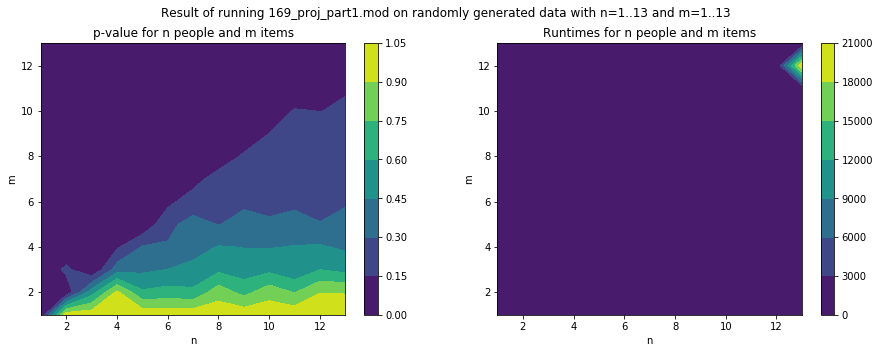

Total runtime: 6069.507814407349 seconds


In [10]:
### PART 1 UP TO 13 ###

start_time = time.time()
gen_data_and_plot(N=13, M=13, ampl_model='169_proj_part1.mod')
print("Total runtime: %s seconds" % (time.time() - start_time))

CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 

CPLEX 12.9.0.0: optimal integer solution; objective 0
20 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.003942964932
206 MIP simplex iterations
59 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.02463846685
597 MIP simplex iterations
72 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.03908636282
46 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.1938050956
7545 MIP simplex iterations
2241 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.2171938997
23812 MIP simplex iterations
7319 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.2056852244
15161 MIP simplex iterations
4823 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution within mipgap or absmipgap; objective 0.2682246524
8740 MIP simplex iterations
1756 branch-and-bound nodes
absmipgap = 2.44897e-06, r

CPLEX 12.9.0.0: optimal integer solution; objective 0
35 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
3719 MIP simplex iterations
873 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.01025958123
158582 MIP simplex iterations
12783 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.03672065044
295151 MIP simplex iterations
17635 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution within mipgap or absmipgap; objective 0.04889642281
451882 MIP simplex iterations
26286 branch-and-bound nodes
absmipgap = 3.38418e-06, relmipgap = 6.92113e-05
CPLEX 12.9.0.0: optimal integer solution; objective 0.03411879472
281491 MIP simplex iterations
12384 branch-and-bound nodes
CPLEX 12.9.0.0: optimal (non-)integer solution; objective 0.03203685057
134253 MIP simplex iterations
9655 branch-and-bound nodes
2 integer variables rounded (maxerr = 1.37543e-08).
Assigning integrality = 7e-0

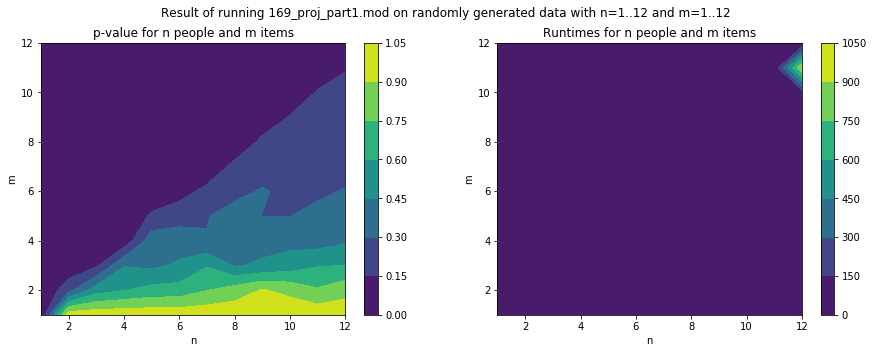

Total runtime: 384.3406677246094 seconds


In [6]:
### PART 1 UP TO 12 ###

start_time = time.time()
gen_data_and_plot(N=12, M=12, ampl_model='169_proj_part1.mod')
print("Total runtime: %s seconds" % (time.time() - start_time))

CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 1
0 MIP simplex iterations
0 

CPLEX 12.9.0.0: optimal integer solution; objective 0.2718707441
99 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.2960346259
17375 MIP simplex iterations
4899 branch-and-bound nodes
CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 0
7 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
6 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.01377086818
447 MIP simplex iterations
124 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.004019970781
327 MIP simplex iterations
63 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.03675905978
643 MIP simplex iterations
69 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.1280458846
1549 MIP simplex iterations
318 branch-and-

CPLEX 12.9.0.0: optimal integer solution within mipgap or absmipgap; objective 0.145888065
15960391 MIP simplex iterations
2014631 branch-and-bound nodes
absmipgap = 1.03163e-05, relmipgap = 7.07135e-05
CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 0
7 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
10 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
15 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
26 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
32 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.01062908188
129467 MIP simplex iterations
10617 branch-and-bound nodes
CPLEX 12.9.0.0: optimal (non-)integer solution; objective 0.0

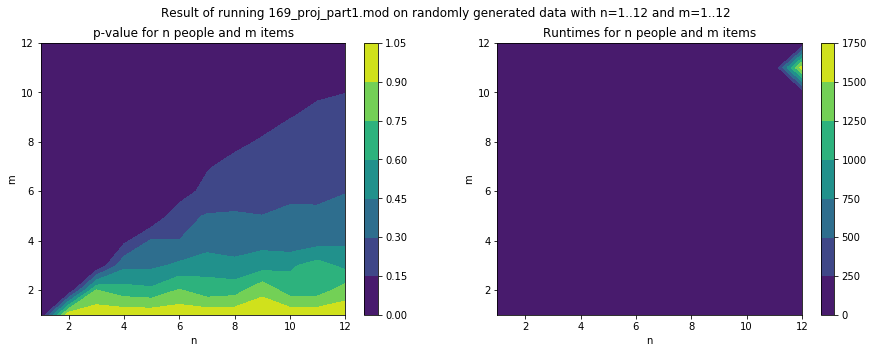

Total runtime: 523.7710647583008 seconds


In [11]:
### PART 1 UP TO 11 ###

start_time = time.time()
gen_data_and_plot(N=12, M=12, ampl_model='169_proj_part1.mod')
print("Total runtime: %s seconds" % (time.time() - start_time))

CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 

CPLEX 12.9.0.0: optimal integer solution; objective 0
496 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
2 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
14 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
31 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
52 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
104 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
61 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
163 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0


CPLEX 12.9.0.0: optimal integer solution; objective 0
669 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
368 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
3 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
21 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
26 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
37 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
67 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
84 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
6

CPLEX 12.9.0.0: optimal integer solution; objective 0
750 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
844 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
5 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
39 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
49 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
81 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
101 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
8

CPLEX 12.9.0.0: optimal integer solution; objective 0
389 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
2000 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
3722 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
6 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
33 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
48 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
56 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
77 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 

CPLEX 12.9.0.0: optimal integer solution; objective 0
561 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
2666 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
1342 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
987 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
5382 MIP simplex iterations
15 branch-and-bound nodes
p-values:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0

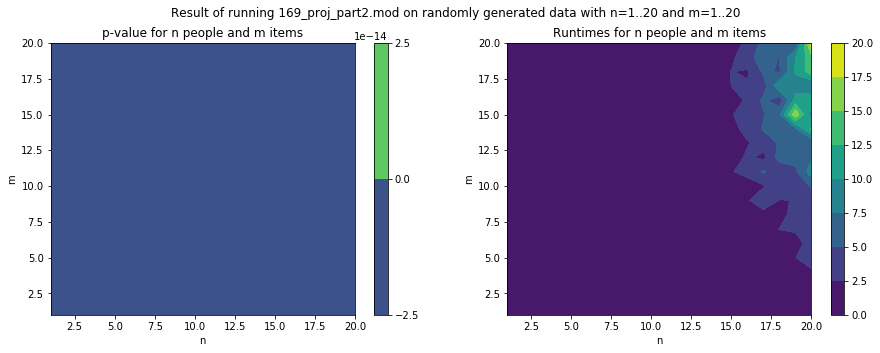

Total runtime: 190.25847172737122 seconds


In [7]:
### PART 2 UP TO 20 ###

start_time = time.time()
gen_data_and_plot(N=20, M=20, ampl_model='169_proj_part2.mod')
print("Total runtime: %s seconds" % (time.time() - start_time))

CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 

CPLEX 12.9.0.0: optimal integer solution; objective 0
43 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
64 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
66 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
136 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
77 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
206 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
235 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
314 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
347 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objectiv

CPLEX 12.9.0.0: optimal integer solution; objective 0
126 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
299 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
121 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
316 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
419 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
355 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
426 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
348 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
718 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; obje

CPLEX 12.9.0.0: optimal integer solution; objective 0
309 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
455 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
481 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
218 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
293 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
490 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
688 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
401 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
578 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; obje

CPLEX 12.9.0.0: optimal integer solution; objective 0
541 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
614 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
922 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
883 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
745 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
802 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
618 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
2198 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
1777 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; ob

CPLEX 12.9.0.0: optimal integer solution; objective 0
1040 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
2547 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
3125 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
3170 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
3006 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
2988 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
2806 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
2701 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution

CPLEX 12.9.0.0: optimal integer solution; objective 0
3511 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
4113 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
1578 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
6038 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
5 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
35 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
0 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
66 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objectiv

CPLEX 12.9.0.0: optimal integer solution; objective 0
65 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
58 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
64 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
115 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
95 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
168 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
137 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
181 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
315 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objectiv

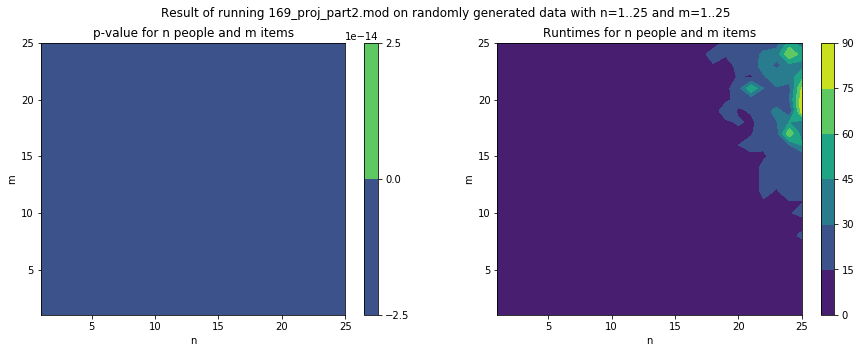

Total runtime: 1222.0301208496094 seconds


In [12]:
### PART 2 UP TO 25 ###

start_time = time.time()
gen_data_and_plot(N=25, M=25, ampl_model='169_proj_part2.mod')
print("Total runtime: %s seconds" % (time.time() - start_time))

CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 0
2 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.1456092133
21 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.1777989428
27 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.2408276125
44 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.2428206424
50 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.3412193592
26 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.3798996836
34 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.3798996836
38 MIP simplex iterations
0 branch-and-bound nod

CPLEX 12.9.0.0: optimal integer solution; objective 0.0921830381
2019 MIP simplex iterations
374 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution within mipgap or absmipgap; objective 0.1106971342
5199 MIP simplex iterations
1004 branch-and-bound nodes
absmipgap = 9.67477e-06, relmipgap = 8.73986e-05
CPLEX 12.9.0.0: optimal integer solution within mipgap or absmipgap; objective 0.1397550342
13087 MIP simplex iterations
3586 branch-and-bound nodes
absmipgap = 5.6954e-06, relmipgap = 4.07527e-05
CPLEX 12.9.0.0: optimal integer solution; objective 0.1556989302
13444 MIP simplex iterations
3285 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.1735403099
16209 MIP simplex iterations
3651 branch-and-bound nodes
CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 0
4 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective

CPLEX 12.9.0.0: optimal integer solution; objective 0.01194065183
23796 MIP simplex iterations
1916 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.02195822954
16389 MIP simplex iterations
1409 branch-and-bound nodes
CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 0
5 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
11 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
20 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
31 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
35 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
2096 MIP simplex iterations
337 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer so

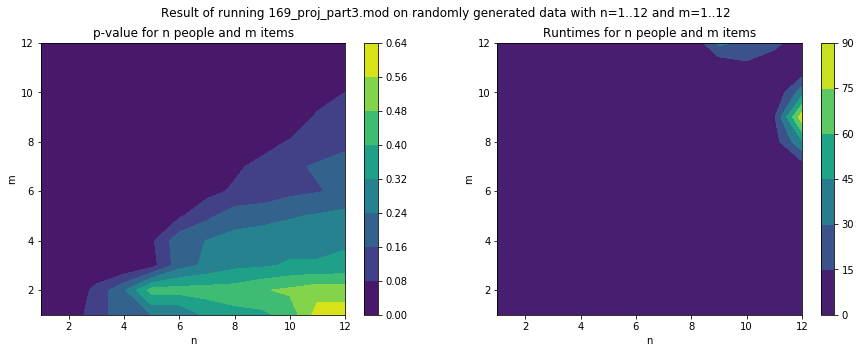

Total runtime: 93.2688262462616 seconds


In [8]:
### PART 3 UP TO 12 ###

start_time = time.time()
gen_data_and_plot(N=12, M=12, ampl_model='169_proj_part3.mod')
print("Total runtime: %s seconds" % (time.time() - start_time))

CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 0
2 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.1456092133
21 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.1777989428
27 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.2408276125
44 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.2428206424
50 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.3412193592
26 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.3798996836
34 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.3798996836
38 MIP simplex iterations
0 branch-and-bound nod

CPLEX 12.9.0.0: optimal integer solution; objective 0.01175549694
512 MIP simplex iterations
88 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0.01175549694
338 MIP simplex iterations
32 branch-and-bound nodes
CPLEX 12.9.0.0: optimal (non-)integer solution; objective 0.0545612172
1022 MIP simplex iterations
113 branch-and-bound nodes
2 integer variables rounded (maxerr = 2.16098e-08).
Assigning integrality = 1e-08 might help.
Currently integrality = 1e-05.
CPLEX 12.9.0.0: optimal integer solution; objective 0.0921830381
2019 MIP simplex iterations
374 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution within mipgap or absmipgap; objective 0.1106971342
5199 MIP simplex iterations
1004 branch-and-bound nodes
absmipgap = 9.67477e-06, relmipgap = 8.73986e-05
CPLEX 12.9.0.0: optimal integer solution within mipgap or absmipgap; objective 0.1397550342
13087 MIP simplex iterations
3586 branch-and-bound nodes
absmipgap = 5.6954e-06, relmipgap = 4.07527e-

CPLEX 12.9.0.0: optimal integer solution; objective 0.08108261597
495212 MIP simplex iterations
51587 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution within mipgap or absmipgap; objective 0.1085957998
3219838 MIP simplex iterations
375452 branch-and-bound nodes
absmipgap = 9.70627e-06, relmipgap = 8.93798e-05
CPLEX 12.9.0.0: optimal solution; objective 0
0 dual simplex iterations (0 in phase I)
CPLEX 12.9.0.0: optimal integer solution; objective 0
6 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
12 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
22 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
20 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
44 MIP simplex iterations
0 branch-and-bound nodes
CPLEX 12.9.0.0: optimal integer solution; objective 0
53 MIP s

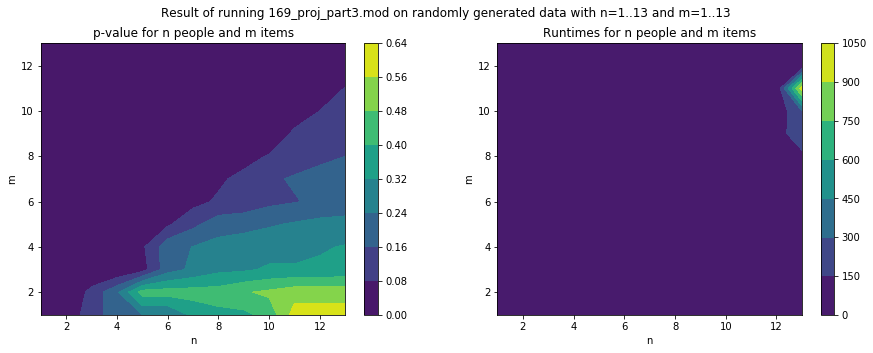

Total runtime: 634.9248762130737 seconds


In [9]:
### PART 3 UP TO 13 ###

start_time = time.time()
gen_data_and_plot(N=13, M=13, ampl_model='169_proj_part3.mod')
print("Total runtime: %s seconds" % (time.time() - start_time))

In [ ]:
# Reference to construct Z list from X and Y

import numpy as np
import matplotlib.pyplot as plt

xr = np.linspace(-5, 5, 100)
yr = np.linspace(0, 5, 110)
X, Y = np.meshgrid(xr, yr)

#Z = 4*X**2 + Y**2

zr = []
for i in range(0, 110):
    y = -25.0 + (50./110.)*float(i)
    for k in range(0, 100):
        x = -20.0 + (40./100.)*float(k)

        v = 4.0*x*x + y*y

        zr.append(v)

Z = np.reshape(zr, X.shape)

print(X.shape)
print(Y.shape)
print(Z.shape)

print(Z)

plt.contour(X, Y, Z)
plt.show()

# Part 4, different methods of generating data for a 4x5 to be more realistic

In [14]:
# function for finding the optimal p value of a given value matrix c

def find_p(c):
    
    ampl = AMPL()
    c = c/c.sum(axis=1,keepdims=1)
    c_df = DataFrame(('I', 'L'), 'c')
    c_df.setValues({
        (i+1, j+1): c[i][j]
        for i in range(4)
        for j in range(5)
    })

    # Solve specified ampl_model with this n-by-m c matrix
    ampl.reset()
    ampl.read('169_proj_part1.mod') # ampl_model string
    ampl.setOption('solver','cplex')
    ampl.getParameter('n').setValues([4])
    ampl.getParameter('m').setValues([5])
    ampl.setData(c_df)
    ampl.solve()
    return ampl.getData('p_max')
    

In [3]:
# No Constraints: Generates a completely random 4x5 matrix from 0 to 1

def no_constraint_data():
    c = np.random.rand(4,5)
    return c

In [4]:
# One Constraint: The second item is always valued less than the first

def one_constraint_data():
    c = np.random.rand(4,5)
    # in every row, replace the second column value with a 
    # random number between 0 and the first column value
    for i in c:
        i[1] = np.random.random()*i[0]
    
    return c
 

In [5]:
# Assorted Constraints 1

def assorted_constraint1_data():
    c = np.random.rand(4,5)

    for i in c:
        i[1] = np.random.random()*i[0]
        i[2] = i[1] + i[0]
        i[3] = 1 - i[2]

    return c


In [16]:
# Assorted Constraints 2

def assorted_constraint2_data():
    c = np.zeros((4,5))

    for i in range(4):
        c[i,4] = np.random.randint(5,10)*100
        c[i,3] = np.random.randint(0, c[i,4])
        c[i,2] = np.random.randint(0,5)*100
        c[i,1] = np.random.randint(c[i,3]/100,20)*100
        c[i,0] = np.random.randint(2*c[i,2]/100,30)*100

    return c


In [7]:
# A 4x5 matrix where all items valued equally by everyone
def equally_valued_data():
    c = np.zeros((4,5))
    random_row = np.random.rand(5)
    
    for row in range(4):
        for col in range(5):
            
            c[row][col] = random_row[col]
    return c

In [8]:
# 4x5 matrix of random samples from a normal distribution.
# warning, negative numbers

def normal_distributed_data():
    c = np.random.normal(0,1,(4,5))
    return c

In [9]:
# generate normally distributed random data with known parameters for item value

# Motorcyle value ~ N(5000,1000)
# Bicycle value ~ N(200,50)
# Dog value ~ N(100,50)
# Painting value ~ N(1500,500)
# Television value ~ N(600,100)

def known_normal_distributed_data():
    c = np.zeros((4,5))
    
    for row in range(4):
        c[row] = generate_random_row()
    return c

def generate_random_row():
    return [np.random.normal(5000,1000),np.random.normal(200,50), np.random.normal(100,50),
                  np.random.normal(1500,500), np.random.normal(600,100)]


In [10]:
import os, sys

class SuppressPrinting:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [17]:
# results of additional constraints

with SuppressPrinting():

    nc_p_values = list()
    oc_p_values = list()
    ac1_p_values = list()
    ac2_p_values = list()
    eq_p_values = list()

    for i in range(200):
        nc_p_values.append(find_p(no_constraint_data()).toList()[0])
        oc_p_values.append(find_p(one_constraint_data()).toList()[0])
        ac1_p_values.append(find_p(assorted_constraint1_data()).toList()[0])
        ac2_p_values.append(find_p(assorted_constraint2_data()).toList()[0])
        eq_p_values.append(find_p(equally_valued_data()).toList()[0])


print('average p values for no constraints: %s ' % np.average(nc_p_values))
print('average p values for one constraint: %s ' %np.average(oc_p_values))
print('average p values for assorted constraints (1): %s ' % np.average(ac1_p_values))
print('average p values for assorted constraints (2): %s ' % np.average(ac2_p_values))
print('average p values when item valuation is constant: %s ' % np.average(eq_p_values))

average p values for no constraints: 0.06046467623547046 
average p values for one constraint: 0.060036092734372534 
average p values for assorted constraints (1): 0.10242226851824789 
average p values for assorted constraints (2): 0.2788710656396403 
average p values when item valuation is constant: 0.18147101569315333 


In [21]:
# results of randomly sampled data from normal distribution
with SuppressPrinting():

    nd_p_values = list()
    knd_p_values = list()
    
    for i in range(200):
        nd_p_values.append(find_p(normal_distributed_data()).toList()[0])
        knd_p_values.append(find_p(known_normal_distributed_data()).toList()[0])
        
    
print('average p values for normally distributed data with standard params: %s' % np.average(nd_p_values))
print('average p values for normally distributed data with known params: %s' % np.average(knd_p_values))



average p values for normally distributed data with standard params: 0.1274779704610123
average p values for normally distributed data with known params: 0.6513756639453071
